<a href="https://colab.research.google.com/github/timothy-voiuhy/CrackDetection/blob/main/crackSegmentationV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics
!pip install torch_xla

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 13.8 MB/s eta 0:00:00


In [2]:
import torch.nn as nn
import torch
import torchvision.transforms.functional as F
from torchvision.transforms import v2
import torch_xla
import torch_xla.core.xla_model as xm
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from torchmetrics.segmentation.generalized_dice import GeneralizedDiceScore
import os

In [ ]:
!kaggle datasets download -d parniashokri/ccssdata
!unzip ccssdata.zip
!ls

In [44]:
# setup dataset directory
try:
    from google.colab import drive
    drive.mount("/content/drive")
    bestModelPath = "/content/drive/MyDrive/Models/CSModel.pt"
    local_dataset_dir = "./CCSS-DATA-V4-withVal/benchmarkingDatasets/"
except Exception as e:
    local_dataset_dir = "/home/kali/AI_ML/DATA/CCSS-DATA-V4-withVal/benchmarkingDatasets/"
    bestModelPath = "./CSModel.pt"
BATCH_SIZE = 64
IMAGE_SIZE = (256, 256)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [8]:
class CracksMaskDataset(Dataset):
    def __init__(self, image_file_paths, mask_file_paths, transform = None):
        super().__init__()
        self.image_file_paths = image_file_paths
        self.mask_file_paths = mask_file_paths
        self.transform = transform

    def load_image_mask(self, image_path, mask_path):
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        image = image.resize(IMAGE_SIZE)
        mask = mask.resize(IMAGE_SIZE)
        return image, mask

    def __getitem__(self, index):
        image_path = self.image_file_paths[index]
        mask_path =  self.mask_file_paths[index]
        image, mask = self.load_image_mask(image_path, mask_path)
        image = transform(image)
        mask = transform(mask)
        mask = v2.Grayscale()(mask)
        return image, mask

    def __len__(self):
        return len(self.image_file_paths)

In [9]:
def createDataLoader(__dir:str):
    image_paths = []
    mask_paths = []
    if not Path(__dir).is_dir():
        print("Directory not found")
        return
    image_dir = __dir+"img" if __dir.endswith("/") else __dir+"/img"
    masks_dir = __dir+"lbl" if __dir.endswith("/") else __dir+"/lbl"
    for image_name, mask_name in zip(os.listdir(image_dir), os.listdir(masks_dir)):
        image_paths.append(os.path.join(image_dir, image_name))
        mask_paths.append(os.path.join(masks_dir, mask_name))

    dataset = CracksMaskDataset(image_file_paths=image_paths,
                                mask_file_paths=mask_paths,
                                transform=transform)

    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE , shuffle=True)

    return dataloader

In [10]:
train_dataloader = createDataLoader(local_dataset_dir+"train/traditionalAugmentation-withPatch")
val_dataloader = createDataLoader(local_dataset_dir+"validation")
test_dataloader = createDataLoader(local_dataset_dir+"test")

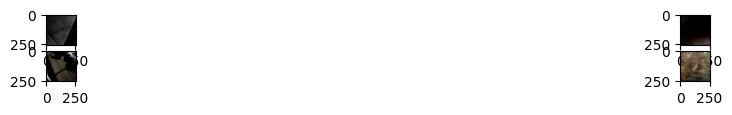

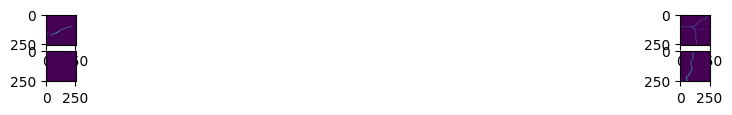

In [11]:
images_iter = iter(train_dataloader)
images, masks = next(images_iter)
images, masks = images[:4], masks[:4]
plt.figure(figsize=(15,30))
columnCount = 2
rowCount = BATCH_SIZE
for idx, image in enumerate(images):
    plt.subplot(rowCount, columnCount, idx+1)
    plt.imshow(image.permute((1,2,0)))

plt.figure(figsize=(15,30))
for idx, mask in enumerate(masks):
    plt.subplot(rowCount, columnCount, idx+1)
    plt.imshow(mask.permute(1,2,0))
plt.show()

In [ ]:
# tensorflow implementation of the unet to be able to use tpus for training


In [46]:
class Unet(nn.Module):
    def __init__(self, ):
        super(Unet, self).__init__()

        # image_shape = (3, 256, 256) # note that the original paper shows an image size of (572, 572) and a bottle neck of (28, 28)
        self.maxPool2d = nn.MaxPool2d(kernel_size=2)

        # encoder downsampling path
        self.enc1 = self.getConvBlock(3, 64) # 252 x 252
        self.enc2 = self.getConvBlock(64, 128)
        self.enc3 = self.getConvBlock(128, 256)
        self.enc4 = self.getConvBlock(256, 512)

        # Bottleneck
        self.bottleneck = self.getConvBlock(512, 1024) # 8 x 8

        # decoder upsampling path with skip connections just
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1 = self.getConvBlock(1024, 512)
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = self.getConvBlock(512, 256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = self.getConvBlock(256, 128)
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4 = self.getConvBlock(128, 64)

        self.fl = nn.Conv2d(in_channels = 64, out_channels=1, kernel_size=(1,1))

    def getConvBlock(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        s1 = self.enc1(x)
        enc1 = self.maxPool2d(s1)
        s2 = self.enc2(enc1)
        enc2 = self.maxPool2d(s2)
        s3 = self.enc3(enc2)
        enc3 = self.maxPool2d(s3)
        s4 = self.enc4(enc3)
        enc4 = self.maxPool2d(s4) # 512

        bottleNeckOutput = self.bottleneck(enc4)

        up1 = self.upconv1(bottleNeckOutput)
        c1 = torch.concat((F.center_crop(s4, [up1.shape[2], up1.shape[3]]), up1), dim=1)
        dec1 = self.dec1(c1)

        up2 = self.upconv2(dec1)
        c2 = torch.concat((F.center_crop(s3, [up2.shape[2], up2.shape[3]]), up2), dim=1)
        dec2 = self.dec2(c2)

        up3 = self.upconv3(dec2)
        c3 = torch.concat((F.center_crop(s2, [up3.shape[2], up3.shape[3]]), up3), dim=1)
        dec3 = self.dec3(c3)

        up4 = self.upconv4(dec3)
        c1 = torch.concat((F.center_crop(s1, [up4.shape[2], up4.shape[3]]), up4), dim=1)
        dec4 = self.dec4(c1)

        return self.fl(dec4)

In [47]:
model = Unet()
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU found")
else:
    print("GPU not found. Using CPU")
    device = torch.device("cpu")
    # device = xm.xla_device()
    # print("Using XLA")
model = model.to(device)

GPU not found. Using CPU


In [48]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
accuracy = GeneralizedDiceScore(num_classes=2)

In [49]:
def computeAccuracy(preds, labels):
    preds = preds.cpu()
    labels = labels.cpu()
    np_preds = nn.Sigmoid()(preds).detach().numpy()
    np_preds = (np_preds >= 0.5).astype(int)
    one_hot_preds = torch.nn.functional.one_hot(torch.from_numpy(np_preds), 2)
    one_hot_labels = torch.nn.functional.one_hot(labels.to(torch.int64), 2)
    acc = accuracy(one_hot_preds, one_hot_labels)
    return acc

def computeLoss(model:Unet, images, labels, train = False, device = device):
    images, labels = images.to(device), labels.to(device)
    preds = model(images)
    loss = loss_fn(preds, labels)
    if train:
        loss.backward()

    acc = computeAccuracy(preds, labels)

    if isinstance(loss, torch.Tensor):
        loss = loss.item()
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return loss, acc

def evaluateModel(model:Unet):
    model.eval()
    with torch.inference_mode():
        total_loss = 0
        total_acc = 0
        for idx, (images, labels) in enumerate(test_dataloader):
            loss, acc = computeLoss(model, images, labels)
            total_loss += loss
            total_acc += acc
        avg_loss = total_loss / len(test_dataloader)
        avg_acc = total_acc / len(test_dataloader)
        print(f"Test Loss: {avg_loss:.5f}, Test Acc: {avg_acc:.5f}")
    return avg_loss, avg_acc

def validateModel(model:Unet):
    model.eval()
    with torch.inference_mode():
        total_loss = 0
        total_acc = 0
        for idx, (images, labels) in enumerate(val_dataloader):
            loss, acc = computeLoss(model, images, labels)
            total_loss += loss
            total_acc += acc
        avg_loss = total_loss / len(val_dataloader)
        avg_acc = total_acc / len(val_dataloader)
    return avg_loss, avg_acc

def trainModel(model:Unet, epochs = 1):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    min_loss_ = float('inf')
    for epoch in range(0, epochs):
        print(f"Epoch: {epoch}")
        model.train()
        epoch_total_loss = 0
        epoch_total_acc = 0
        for idx, (images, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_loss, train_acc = computeLoss(model, images, labels, train = True)
            epoch_total_loss += train_loss
            epoch_total_acc += train_acc
            # train_loss.backward()
            optimizer.step()

            if idx % 30 == 0:
                print(f"\tStep: {idx}/{len(train_dataloader)} Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f}")

        val_loss, val_acc = validateModel(model)

        train_loss = epoch_total_loss / len(train_dataloader)
        train_acc = epoch_total_acc / len(train_dataloader)

        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch: {epoch}, Train Loss: {train_loss:.5f}, Train Acc: {train_acc:5f}, Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.5f}")
        if val_loss < min_loss_:
            print(f"Model val_loss improved from {min_loss_} to {val_loss}")
            min_loss_ = val_loss
            torch.save(model.state_dict(), bestModelPath)
            print(f"Model Saved to file: {bestModelPath}")
        else:
            print(f"Model val_loss did not improve from {min_loss_}")
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [50]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = trainModel(model, epochs=1)

Epoch: 0
	Step: 0/44 Train Loss: 0.44259, Train Acc: 0.78316
	Step: 30/44 Train Loss: -1.49240, Train Acc: 0.99777
Epoch: 0, Train Loss: -1.17018, Train Acc: 0.982307, Val Loss: -1.81451, Val Acc: 0.99999
Model val_loss improved from inf to -1.814508318901062
Model Saved to file: /content/drive/MyDrive/Models/CSModel.pt


In [51]:
evaluateModel(model)

Test Loss: -1.81626, Test Acc: 0.99999


(-1.816258043050766, 0.9999854564666748)

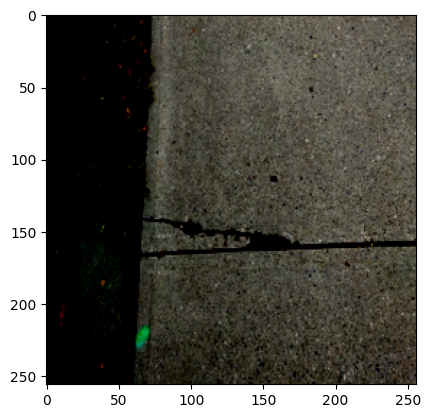

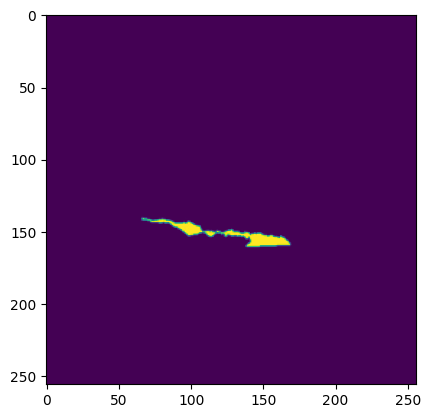

In [52]:
test_images, test_masks = next(iter(test_dataloader))
test_image, test_mask = test_images[0], test_masks[0]
model.eval()
with torch.inference_mode():
    test_pred = model(test_image.unsqueeze(0).to(device))
plt.imshow(test_image.permute(1,2,0))
plt.show()
plt.imshow(test_mask.permute(1,2,0))
plt.show()

In [53]:
# model.save(bestModelPath)
torch.save(model.state_dict(), bestModelPath)